### Understand Problem and Data

The dataset include 38 classes of both healthy and diseased leaves. The training dataset has 21917 images.



In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "sample/"
train="sample/valid/"
valid= "sample/valid/"
arch=vgg16
bs=64
sz=224

### Number of images per class visualization

In [3]:
images_per_class = {}
for class_folder_name in os.listdir(valid):
    class_folder_path = os.path.join(valid, class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.*")):
        #image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_path)

In [74]:
for key,value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))

.DS_Store -> 0
c_0 -> 270
c_1 -> 280
c_10 -> 445
c_11 -> 476
c_12 -> 552
c_13 -> 420
c_14 -> 171
c_15 -> 2321
c_16 -> 962
c_17 -> 108
c_18 -> 428
c_19 -> 577
c_2 -> 124
c_20 -> 412
c_21 -> 380
c_22 -> 64
c_23 -> 240
c_24 -> 1917
c_25 -> 749
c_26 -> 390
c_27 -> 214
c_28 -> 792
c_29 -> 405
c_3 -> 713
c_30 -> 726
c_31 -> 360
c_32 -> 734
c_33 -> 720
c_34 -> 547
c_35 -> 2100
c_36 -> 139
c_37 -> 643
c_4 -> 586
c_5 -> 510
c_6 -> 358
c_7 -> 191
c_8 -> 519
c_9 -> 374


In [259]:
def plot_for_class():
    nb_rows = 10
    nb_cols = 4
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(18, 38),sharex=True)
    n = 0
    label=0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            im=Image.open(images_per_class[str(label)][0])
            axs[i,j].xaxis.set_ticklabels([])
            axs[i,j].yaxis.set_ticklabels([])
            axs[i,j].imshow(im)
            n += 1 
            label=label+1
            if(label==38):break

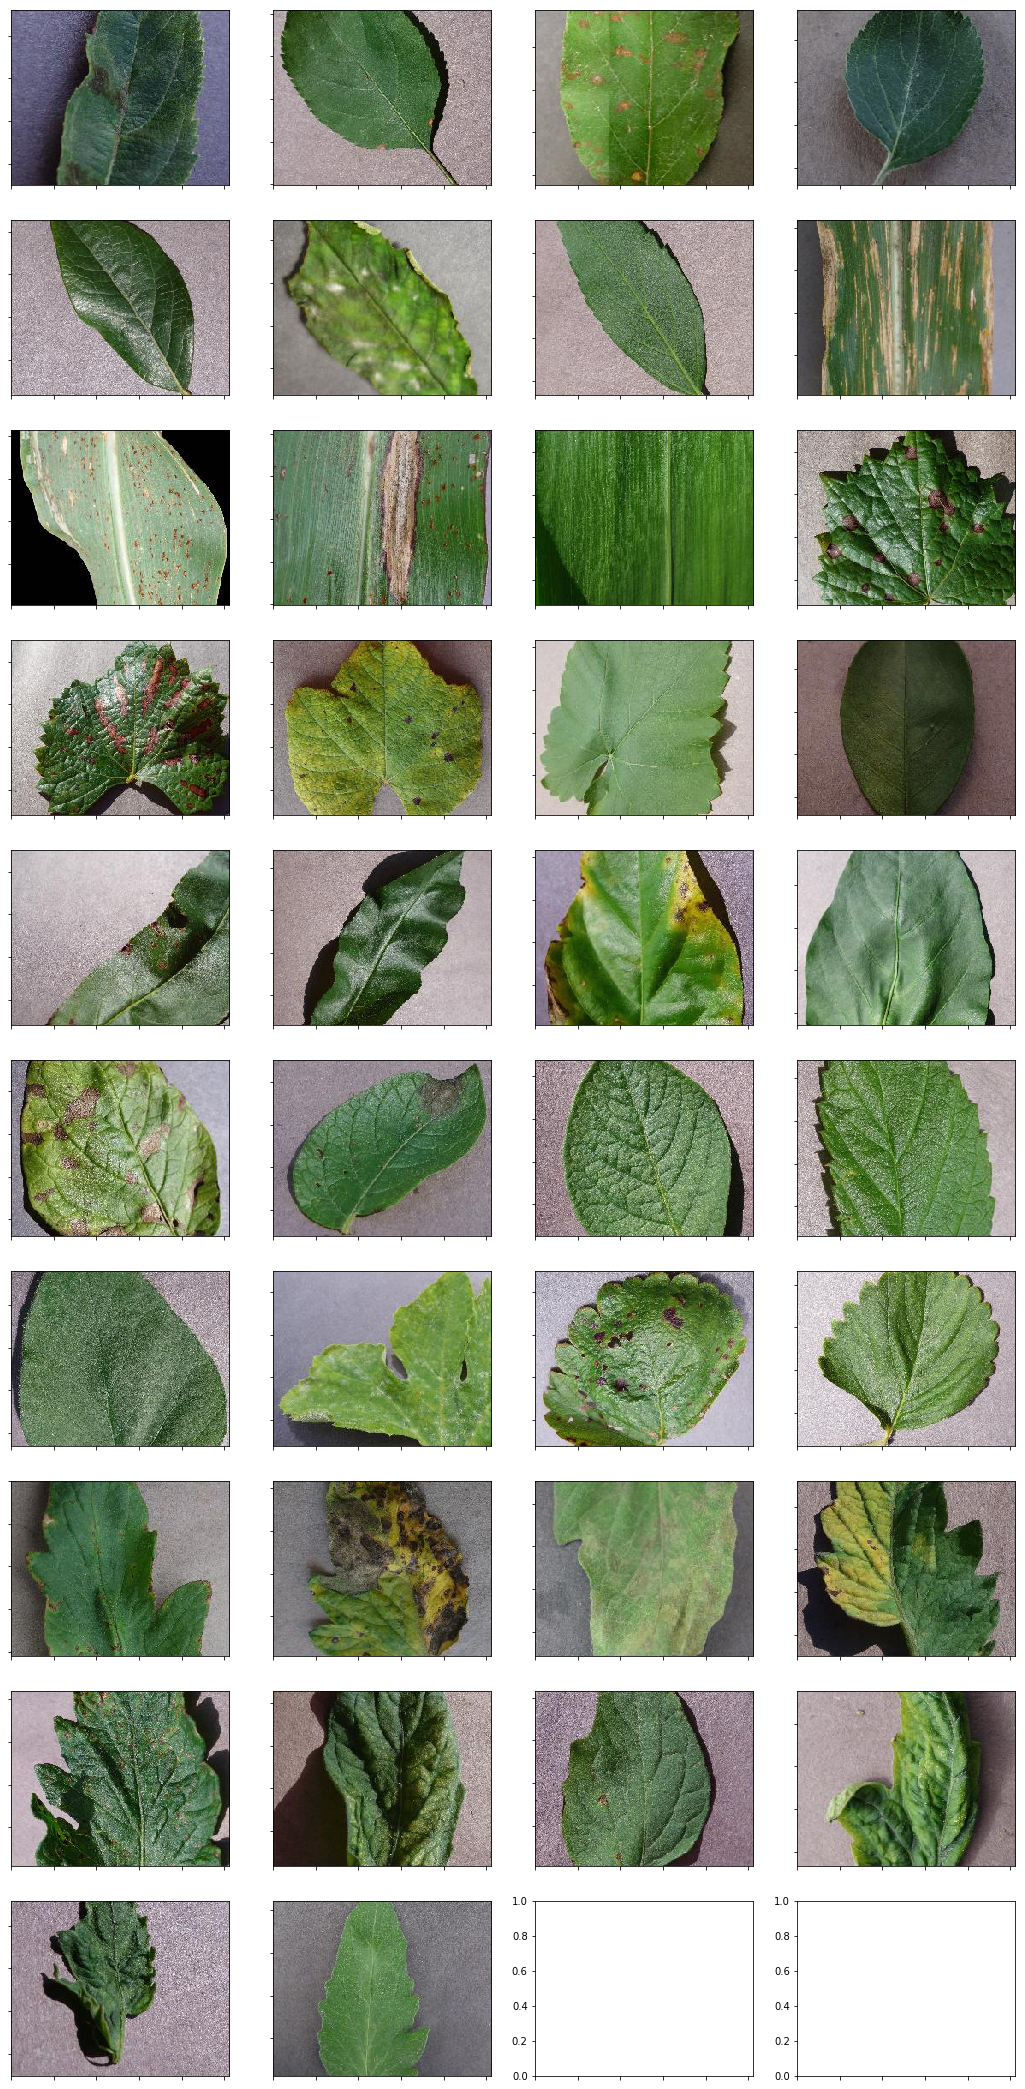

In [260]:
plot_for_class()

In [ ]:
plot_for_class('1')

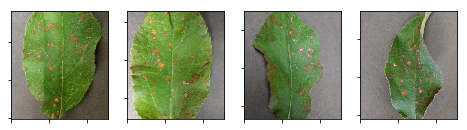

In [215]:
plot_for_class('2')

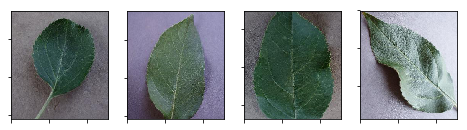

In [216]:
plot_for_class('3')

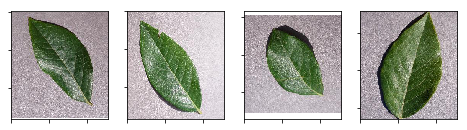

In [217]:
plot_for_class('4')

### Segmentation

Ref : https://www.kaggle.com/gaborvecsei/plant-seedlings-fun-with-computer-vision

In [287]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

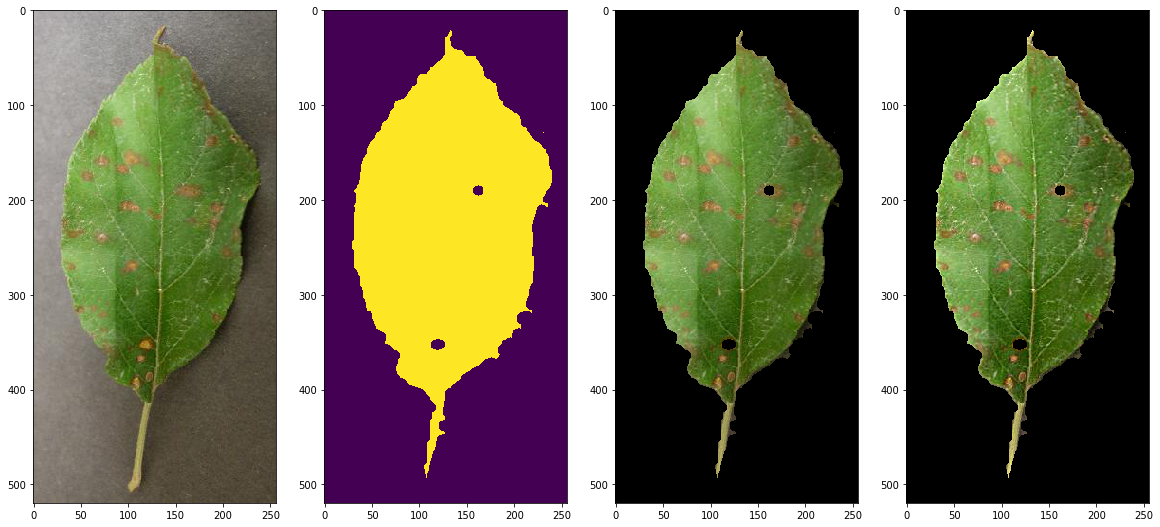

In [299]:
# Test image to see the changes
image = Image.open(images_per_class["2"][0])

type(image)

image_data = np.asarray(image)

image_mask = create_mask_for_plant(image_data)
image_segmented = segment_plant(image_data)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen);

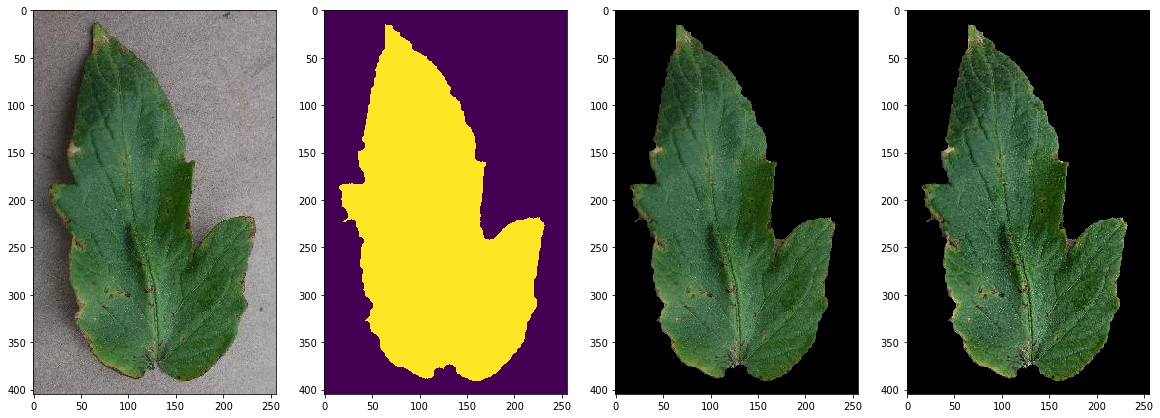

In [300]:
# Test image to see the changes
image = Image.open(images_per_class["28"][0])

type(image)

image_data = np.asarray(image)

image_mask = create_mask_for_plant(image_data)
image_segmented = segment_plant(image_data)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen);

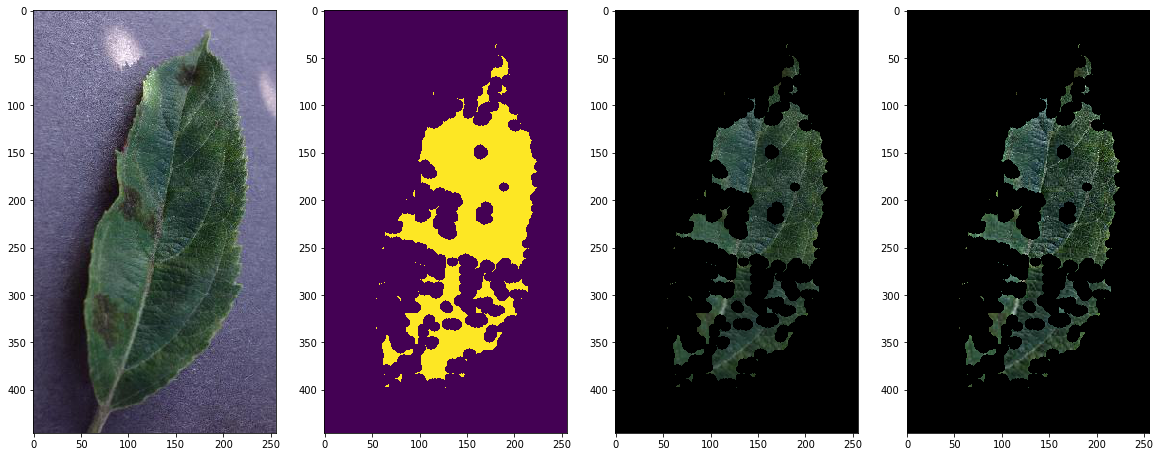

In [301]:
# Test image to see the changes
image = Image.open(images_per_class["0"][0])
image_data = np.asarray(image)

image_mask = create_mask_for_plant(image_data)
image_segmented = segment_plant(image_data)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen);

In [303]:
def find_contours(mask_image):
    return cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

def calculate_largest_contour_area(contours):
    if len(contours) == 0:
        return 0
    c = max(contours, key=cv2.contourArea)
    return cv2.contourArea(c)

def calculate_contours_area(contours, min_contour_area = 250):
    area = 0
    for c in contours:
        c_area = cv2.contourArea(c)
        if c_area >= min_contour_area:
            area += c_area
    return area

In [305]:
areas = []
larges_contour_areas = []
labels = []
nb_of_contours = []
images_height = []
images_width = []

for class_label in images_per_class.keys():
    for im in images_per_class[class_label]:
        image = Image.open(im)
        image_data = np.asarray(image)

        mask = create_mask_for_plant(image_data)
        contours = find_contours(mask)
        
        area = calculate_contours_area(contours)
        largest_area = calculate_largest_contour_area(contours)
        height, width, channels = image_data.shape
        
        images_height.append(height)
        images_width.append(width)
        areas.append(area)
        nb_of_contours.append(len(contours))
        larges_contour_areas.append(largest_area)
        labels.append(class_label)

In [306]:
features_df = pd.DataFrame()
features_df["label"] = labels
features_df["area"] = areas
features_df["largest_area"] = larges_contour_areas
features_df["number_of_components"] = nb_of_contours
features_df["height"] = images_height
features_df["width"] = images_width
features_df.groupby("label").describe()


area                                                              \
       count           mean           std      min        25%        50%   
label                                                                      
0       24.0   34748.979167  12310.987462  18454.0  25913.625   32752.75   
1       19.0   25503.684211  12828.506008    717.0  18290.250   24414.50   
10       2.0  107500.500000  34791.774955  82899.0  95199.750  107500.50   
11      50.0   27671.770000   5224.729609  11139.5  24385.125   28741.50   
12      36.0   25450.125000   5434.798554  13003.0  22969.250   26154.50   
13      26.0   37967.653846   4770.280570  27665.5  35980.250   38249.50   
14      14.0   27613.714286  11246.228740  11397.5  17929.875   31208.50   
15     162.0   52272.061728  15147.107852   5403.0  42598.250   55123.50   
16      58.0   22501.732759  19182.761093      0.0  10358.375   16655.00   
17      10.0   12880.050000   9696.072898      0.0   3443.250   15909.00   
18      28.0   48520.017857  13589.132307  22656.0  39931.000   49145.00   
19      40.0   34313.462500  15226.519919   5506.5  21933.250   36481.00   
2        7.0   35498.142857  15779.428345  19115.5  23612.000   30044.50   
20      34.0   42433.764706  14092.630532  15768.5  31165.500   40144.25   
21      34.0   29348.617647  12867.597353   2959.0  21869.375   26768.25   
22       6.0   43138.666667   4442.108212  37877.0  39392.125   43729.75   
23      17.0   45594.882353  10415.684781  29669.0  40173.500   44122.00   
24     132.0   19806.303030  17758.274537    395.0   6567.625   12266.50   
25      49.0   33620.795918  19454.276517      0.0  13952.500   33661.00   
26      23.0   28571.630435  14675.452933   5843.0  16252.250   31723.50   
27       6.0   34126.416667   5526.124876  28725.5  32045.875   32992.75   
28      51.0   45435.558824  19667.743451   2374.0  31628.000   46392.00   
29      25.0   27642.860000  11820.672730   1553.0  18905.000   28351.50   
3       53.0   12914.886792  10834.941928      0.0   3429.500   13232.50   
30      57.0   19447.780702  12080.082139    827.5  11842.000   17881.50   
31      18.0   24257.361111  13050.863367   5068.5  15778.000   22089.50   
32      39.0   30403.871795  13608.704955   7250.0  20906.500   29237.00   
33      56.0   28717.357143   9231.768444   7273.5  22547.625   28803.75   
34      42.0   22942.547619  12707.003808   3375.5  12692.625   22107.75   
35     161.0   39425.347826  14007.430342   3033.5  29747.000   37635.00   
36      13.0   21906.769231   7605.735390  12096.0  15616.000   21139.00   
37      42.0   21578.892857  16299.793291    814.0   6140.625   19537.25   
4       33.0   23637.045455  10596.951204   4504.5  16808.500   22870.00   
5       31.0   38114.112903  26762.409189      0.0  19292.500   32479.00   
6       35.0   51591.042857  20758.589096   5263.5  34145.000   58730.50   
7       13.0   33429.692308  16019.197000   4612.0  23072.500   31691.00   
8       33.0   33547.469697  18486.356212   3945.5  17727.000   32727.00   
9       21.0   30362.880952  20901.607303   1139.0  20474.500   25087.50   

                            height              ...   number_of_components  \
              75%       max  count        mean  ...                    75%   
label                                           ...                          
0       44956.250   58216.0   24.0  346.708333  ...                  16.00   
1       34579.000   46236.0   19.0  392.526316  ...                  20.00   
10     119801.250  132102.0    2.0  305.500000  ...                   3.25   
11      31234.375   36914.5   50.0  272.940000  ...                  12.00   
12      29447.125   32556.0   36.0  273.083333  ...                  16.25   
13      39762.750   49103.0   26.0  273.307692  ...                   1.75   
14      32749.250   46620.0   14.0  283.357143  ...                  34.75   
15      62233.625   81760.0  162.0  463.037037  ...                   6.00   
16      25101.250   87227.5   58.

### Modelling

In [4]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [5]:
torch.cuda.is_available()

False

In [6]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [7]:
learn.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      2.500786   1.946259   0.552     
    1      1.705101   1.082941   0.743333                 
    2      1.257706   0.827612   0.798667                 



[array([ 0.82761]), 0.79866666666666664]

In [8]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [9]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [13]:
learn.fit(0.1, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.31329  0.34821  0.89565]                      
[ 1.       0.24496  0.34335  0.89565]                      
[ 2.       0.19632  0.3404   0.90244]                      



### Analyzing results: looking at pictures

In [307]:
#actual labels for val data i.e ground truth
data.val_y

array([ 0,  0,  0, ..., 37, 37, 37])

In [12]:
data.classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [27]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(1500, 38)

In [37]:
log_preds[:,0]

array([-3.59179, -1.79704, -2.17461, ..., -6.60876, -6.41833, -5.41798], dtype=float32)

In [28]:
log_preds[:10]

array([[ -3.59179,  -4.59776,  -5.1949 ,  -6.42207,  -5.89438,  -6.50511,  -5.87831,  -4.28121,  -3.08209,
         -4.63808,  -3.42929,  -3.82054,  -4.73927,  -5.92794,  -4.66739,  -5.97061,  -4.94877,  -5.33577,
         -6.43331,  -5.97088,  -5.64361,  -1.4519 ,  -5.76674,  -1.03417,  -6.26339,  -4.01434,  -5.29726,
         -4.47802,  -4.22016,  -4.12254,  -4.90954,  -2.69662,  -4.34715,  -3.99427,  -5.80615,  -5.71381,
         -5.90835,  -5.06638],
       [ -1.79704,  -2.30784,  -4.3672 ,  -4.64432,  -4.49509,  -3.97292,  -2.75673,  -8.71869,  -5.22288,
         -4.50533,  -5.99902,  -6.72264,  -4.94743,  -3.59107,  -4.58256,  -5.12612,  -3.2355 ,  -5.18236,
         -3.91069,  -2.60104,  -4.0026 ,  -4.5514 ,  -6.63421,  -2.89451,  -6.1451 ,  -3.92494,  -2.95234,
         -4.37811,  -3.42485,  -7.22053,  -4.34561,  -2.32112,  -4.52181,  -4.62205,  -3.1055 ,  -5.01433,
         -4.07501,  -5.81646],
       [ -2.17461,  -4.46924,  -4.70283,  -4.13551,  -4.87551,  -5.00003,  -4.3913

In [32]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
preds[:20]

array([23,  0,  8, 31, 23,  8, 23,  1,  0, 21,  0, 23, 18, 19,  8, 18, 10,  0,  8, 23])

In [107]:
probs = np.exp(log_preds[:,0])        # pr(oth class)
probs

array([ 0.02755,  0.16579,  0.11365, ...,  0.00135,  0.00163,  0.00444], dtype=float32)

In [109]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 8, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [58]:
rand_by_mask((preds == data.val_y)==True)

array([ 519, 1371,  528, 1141])

In [104]:
idxs=rand_by_correct(True)
imgs = np.stack([data.val_ds[x][0] for x in idxs])
labels= np.stack([data.val_ds[x][1] for x in idxs])
labels

array([ 3,  5,  5, 24])

In [112]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    labels= np.stack([data.val_ds[x][1] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    #titles=labels + " " + title_probs
    return plots(data.val_ds.denorm(imgs), rows=1, titles=labels)

In [23]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [24]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

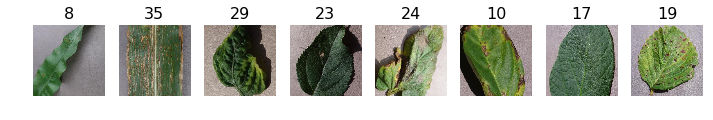

In [113]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

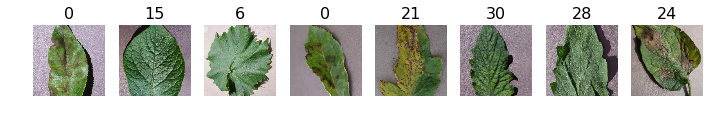

In [261]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [262]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

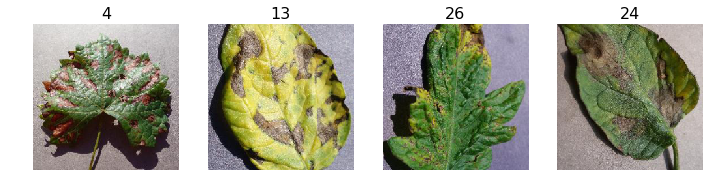

In [263]:
plot_val_with_title(most_by_correct(0, True), "Most correct ")

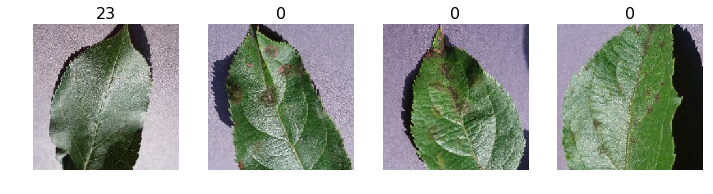

In [264]:
plot_val_with_title(most_by_correct(1, True), "Most correct ")

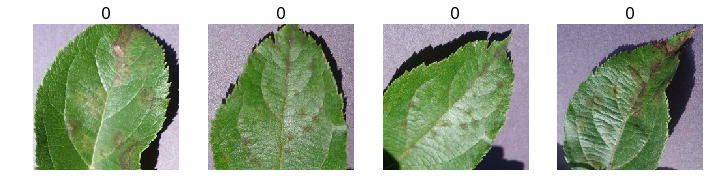

In [308]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [279]:
#correct_cats = np.where((preds==0) & (preds==data.val_y[:,1]))[0] 
data[:,:2]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plot_val_with_title(correct_cats[most_correct_cats], "")#probs[correct_cats][most_correct_cats])

TypeError: 'ImageClassifierData' object is not subscriptable

[[ 5  1  0 ...,  0  0  0]
 [ 0 17  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  2]
 ..., 
 [ 0  0  0 ...,  7  0  6]
 [ 0  0  0 ...,  0 33  0]
 [ 0  1  0 ...,  1  2 17]]


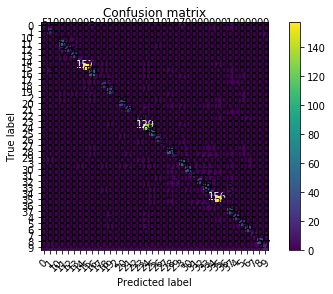

In [99]:
cm = confusion_matrix(data.val_y, preds)
#plt.Figure(figsize=(10,10))
plot_confusion_matrix(cm, data.classes,cmap='viridis');


In [42]:
cm[:3]

array([[ 5,  1,  0,  0,  0,  0,  0,  0,  5,  0,  1,  0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  1,  0,  7,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2]])

In [59]:
from sklearn.metrics import classification_report , confusion_matrix, accuracy_score
print(accuracy_score(data.val_y, preds))
print(confusion_matrix(data.val_y, preds))
print(classification_report(data.val_y, preds))

0.829333333333
[[ 5  1  0 ...,  0  0  0]
 [ 0 17  0 ...,  0  0  0]
 [ 0  0  0 ...,  0  0  2]
 ..., 
 [ 0  0  0 ...,  7  0  6]
 [ 0  0  0 ...,  0 33  0]
 [ 0  1  0 ...,  1  2 17]]
             precision    recall  f1-score   support

          0       1.00      0.21      0.34        24
          1       0.74      0.89      0.81        19
          2       0.00      0.00      0.00         2
          3       0.80      0.94      0.86        50
          4       0.92      0.67      0.77        36
          5       0.84      1.00      0.91        26
          6       0.92      0.86      0.89        14
          7       0.98      0.97      0.98       162
          8       0.79      0.86      0.83        58
          9       1.00      0.10      0.18        10
         10       0.81      0.75      0.78        28
         11       0.77      0.93      0.84        40
         12       0.00      0.00      0.00         7
         13       0.88      0.85      0.87        34
         14       0.86   

/Users/vishnu/anaconda/envs/poonam/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [98]:
sum=0
for key,value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))
    sum=sum+len(value)
print(sum)

0 -> 24
1 -> 19
10 -> 2
11 -> 50
12 -> 36
13 -> 26
14 -> 14
15 -> 162
16 -> 58
17 -> 10
18 -> 28
19 -> 40
2 -> 7
20 -> 34
21 -> 34
22 -> 6
23 -> 17
24 -> 132
25 -> 49
26 -> 23
27 -> 6
28 -> 51
29 -> 25
3 -> 53
30 -> 57
31 -> 18
32 -> 39
33 -> 56
34 -> 42
35 -> 161
36 -> 13
37 -> 42
4 -> 33
5 -> 31
6 -> 35
7 -> 13
8 -> 33
9 -> 21
1500


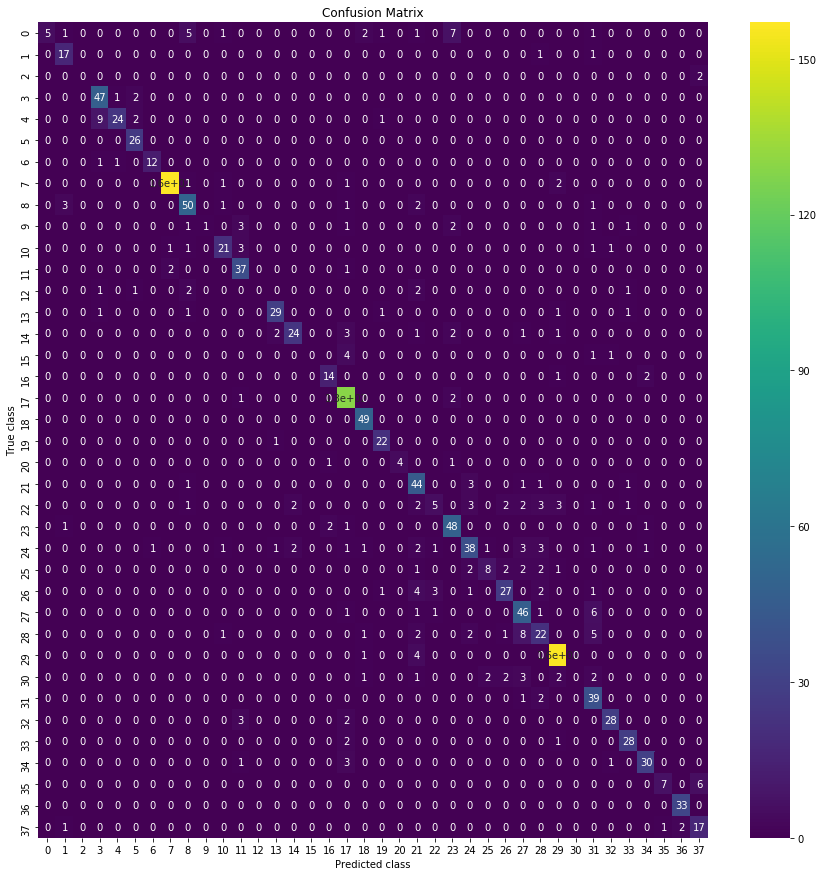

In [100]:
fig, ax = plt.subplots(1,figsize=(15,15))
ax = sns.heatmap(cm, ax=ax, cmap=plt.cm.viridis, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
#fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

### Choosing a learning rate

In [10]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [11]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▉ | 42/47 [00:01<00:00, 36.86it/s, loss=20.9]


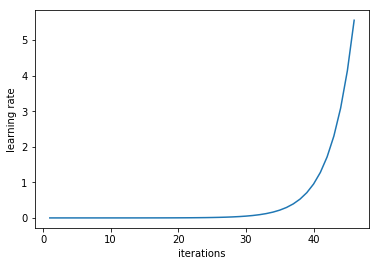

In [12]:
learn.sched.plot_lr()

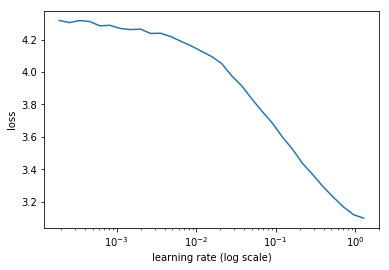

In [13]:
learn.sched.plot()

### Improving model

#### Data Augmentation

In [17]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [15]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [16]:
ims = np.stack([get_augs() for i in range(6)])

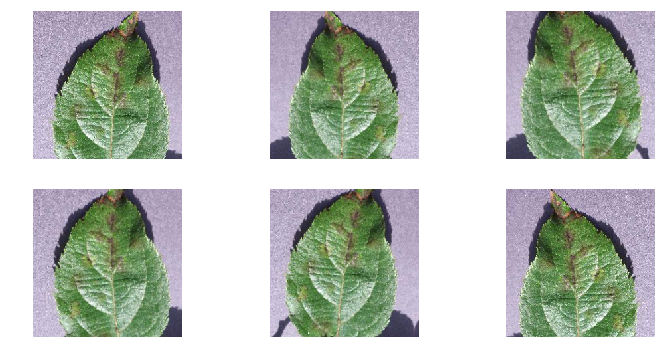

In [17]:
plots(ims, rows=2)

In [18]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

In [19]:
learn = ConvLearner.pretrained(arch, data,precompute=True)

In [20]:
learn.precompute=False

In [ ]:
learn.fit(0.1, 2, cycle_len=1)

  0%|          | 0/47 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   accuracy                 
    0      1.470324   0.737659   0.818667  


In [ ]:
learn.precompute=False
learn.fit(0.1, 2,cycle_len=3)


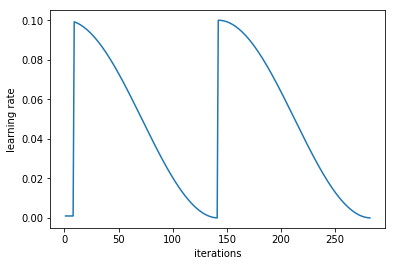

In [21]:
learn.sched.plot_lr()

In [33]:
learn.fit(0.01, 2,cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       0.07506  0.25991  0.91704]                       
[ 1.       0.06979  0.25855  0.91183]                       
[ 2.       0.07095  0.254    0.91704]                       
[ 3.       0.07117  0.25175  0.91834]                       



In [13]:
learn.save('224_lastlayer')

In [14]:
learn.unfreeze()

In [15]:
lr=np.array([1e-3,1e-2,1e-1])

In [16]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

KeyError: <weakref at 0x1c46c49e08; to 'tqdm' at 0x1c25e55e10>